In [227]:
from week1 import box3d, PiInv, Pi,project_points,plot3d
import numpy as np 
import matplotlib.pyplot as plt 
from sympy import Matrix

Exercise 2.1
Reuse the box3d function from last week. Assume that f = 600, α = 1, β = 0, and δx = δy = 400.
Given a traditional camera, what is the resolution in pixels?
Also assume R = I, and t = [0, .2, 1.5]T. Use projectpoints from last week, to project the
points.

In [228]:
#Define the given parameters 

Q = box3d()
f = 600
beta = 0
alpha = 1 
dx = 400
dy = 400

K = np.array([[f,f*beta,dx],[0,alpha*f,dy],[0,0,1]])
R = np.eye(3)
t = np.array([0,0.2,1.5])

#The projected points 
p = project_points(K,R,t,Q)

Are all the points captured by the image sensor?

In [229]:
#The projection matrix 

P = K@np.column_stack((R,t))
Matrix(P)

⎡600.0    0    400.0  600.0⎤
⎢                          ⎥
⎢  0    600.0  400.0  720.0⎥
⎢                          ⎥
⎣  0      0     1.0    1.5 ⎦

2 x 400 = 800 pixels along each dimensions, i.e. 800 x 800.

Where does the corner P 1 = [−0.5, −0.5, −0.5] project to?


In [1238]:
corner = np.array([-0.5,-0.5,-0.5])

projectpoint(K,R,t,corner)

array([100., 220.,   1.])

The corner projects to [100,220].T

#### Create a new or change your function projectpoints to a version that also takes distCoeffs as
#### an input. The list distCoeffs should contain the distortion coefficients [k3, k5, k7, . . . ]. Make the function work for at least 3 coefficients.


In [1234]:
def PiInv(coordinate):
    """
    Convert inhomogeneous coordinates to homogeneous coordinates.

    Parameters:
    - coordinate: A numpy array of inhomogeneous coordinates. This can be a 1D array (vector) or a 2D array (matrix).

    Returns:
    - A numpy array of homogeneous coordinates. For a vector, appends a 1 to the end. For a matrix, appends a row of 1s.
    """

    # Handle 1D array (vector) case
    if coordinate.ndim == 1:
        hom = np.append(coordinate, 1)
    # Handle 2D array (matrix) case
    elif coordinate.ndim == 2:
        w = np.ones((1, coordinate.shape[1]))
        hom = np.vstack((coordinate, w))
    else:
        raise ValueError("Input must be a 1D (vector) or 2D (matrix) array.")

    return hom


Exercise 2.1


In [1236]:
"""def dist(coef,p):
    powers = np.arange(2,len(coef)*2+1,2)
    p =  Pi(p) 
    r_i = np.sqrt(p[0]**2+p[1]**2)
    delta_r_i =   np.array(coef) *  np.power(r_i,powers)
    p = p * (1+delta_r_i) 

    return p
"""

def dist(coef,p):
    powers = np.arange(2,len(coef)*2+1,2)
    p =  Pi(p) 
    r_i = np.sqrt(p[0]**2+p[1]**2)
    r_i_powers = np.power(r_i.reshape(-1,1)[:,np.newaxis],powers)
    delta_r_i = r_i_powers @ np.array(coef)
    p = p.T * (1+delta_r_i) 

    return p.T


def projectpoint(K,R,t,Q,coef = None ):
    if coef is not None:
        p = np.hstack((R,t.reshape(-1,1))) @ PiInv(Q)
        q = K@PiInv(dist(coef,p))
        return q
    else:
            p = K @ np.column_stack((R,t)) @ PiInv(Q)
            return p


In [1239]:
K = np.array([[600,0,400],[0,600,400],[0,0,1]])
R = np.array([[1,0,0],[0,1,0],[0,0,1]])
t = np.array([0,0.2,1.5])
Q = np.array([-0.5,-0.5,-0.5])

projectpoint(K,R,t,Q,[-0.2]).T

array([[120.4 , 232.24,   1.  ]])

Text(0.5, 1.0, 'Unidstorted')

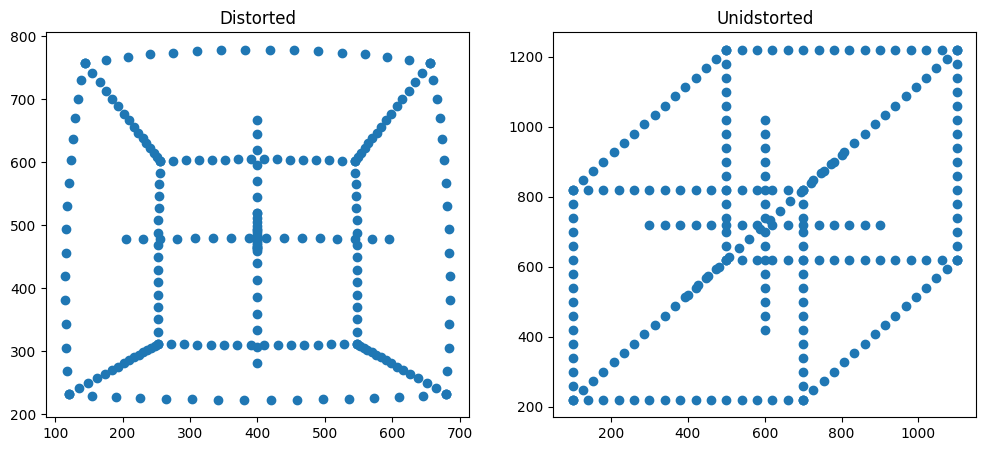

In [1190]:
Q = box3d() 
x_d,y_d,_ = (projectpoint(K,R,t,Q))
x_c,y_c,_ = (projectpoint(K,R,t,Q,[-0.2]))


fig,ax = plt.subplots(1,2,figsize=(12,5))


ax[0].scatter(x_c,y_c)
ax[1].scatter(x_d,y_d)


ax[0].set_title("Distorted")
ax[1].set_title("Unidstorted")


Exercise 2.3


In [1240]:
import cv2 
im = cv2.imread("gopro_robot.jpg")[:,:,::-1]
im = im.astype(float)/255

f = 0.455732 * im.shape[1]

In [1243]:
delta_x = im.shape[1]/2
delta_y = im.shape[0]/2

print(delta_x , delta_y)

960.0 540.0


In [1244]:
K = np.array([[f,0,delta_x],[0,f,delta_y],[0,0,1]])
Matrix(K)

⎡875.00544      0      960.0⎤
⎢                           ⎥
⎢    0      875.00544  540.0⎥
⎢                           ⎥
⎣    0          0       1.0 ⎦

Exercise 2.4


In [1245]:
"""
TODO: Fix this shit
This function is not working correctly for the time being, To be continued later.
"""
def undistortImage(im,K,k):

    x, y = np.meshgrid(np.arange(im.shape[1]), np.arange(im.shape[0]))
    p = np.stack((x, y, np.ones(x.shape))).reshape(3, -1)
    q = np.linalg.inv(K) @ (p)
    q_d = PiInv(dist(k,q))
    p_d = K @ q_d
    x_d = p_d[0].reshape(x.shape).astype(np.float32)
    y_d = p_d[1].reshape(y.shape).astype(np.float32)
    assert (p_d[2]==1).all(), 'You did a mistake somewhere'
    im_undistorted = cv2.remap(im, x_d, y_d, cv2.INTER_LINEAR)

    return im_undistorted

In [1246]:
k = [-0.245031,0.071524,-0.00994978]
undistorted = undistortImage(im,K,k)


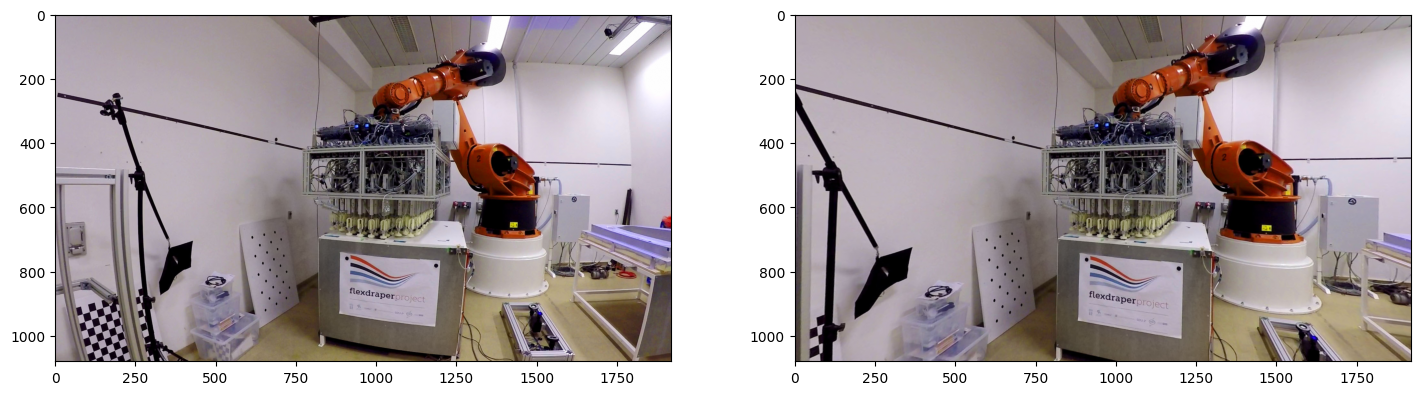

In [1247]:
fig,ax = plt.subplots(1,2,figsize=(17.5,10))
ax[1].imshow(undistorted)
ax[0].imshow(im)

Exercise 2.5


Homographies
Exercise 2.5

In [1344]:
from sympy import Matrix 

p1 = np.array([1,1])
p2 = np.array([0,3]) 
p3 = np.array([2,3])
p4 = np.array([2,4]) 

H = np.array([[-2,0,1],[1,-2,0],[0,0,3]])


q1 = Pi(H@PiInv(p1))
q2 = Pi(H@PiInv(p2))
q3 = Pi(H@PiInv(p3))
q4 = Pi(H@PiInv(p4))


print("The mapped coordinates are: ") 
Matrix(q1), Matrix(q2), Matrix(q3), Matrix(q4)



The mapped coordinates are: 


⎛⎡-0.333333333333333⎤  ⎡0.333333333333333⎤  ⎡      -1.0       ⎤  ⎡-1.0⎤⎞
⎜⎢                  ⎥, ⎢                 ⎥, ⎢                 ⎥, ⎢    ⎥⎟
⎝⎣-0.333333333333333⎦  ⎣      -2.0       ⎦  ⎣-1.33333333333333⎦  ⎣-2.0⎦⎠

In [1502]:
np.linalg.norm(F)

In [1546]:
def hest(q1,q2):
    #B = np.array([[0,-q2[0],q2[0]*q1[1],0,-q2[1],q2[1]*q1[1],0,-1,q1[1]],[q2[0],0,-q2[0]*q1[0],q2[1],0,-q2[1]*q1[0],1,0,-q1[0]],[-q2[0]*q1[1],q1[0]*q2[0],0,-q2[1]*q1[1],q2[1]*q1[0],0,-q1[1],q1[0],0]])
    q11 = np.array([[0,-1,q1[1]],[1,0,-q1[0]],[-q1[1],q1[0],0]])
    B = np.kron(PiInv(q2).reshape(1,3),q11)
    U,S,VT = np.linalg.svd(B)
    H = VT[-1,:].reshape(3,3).T
    return H


hest(p1,p2)

array([[-0.2236068 ,  0.09863014,  0.03744292],
       [-0.01414788,  0.10068493,  0.03127854],
       [-0.14334554, -0.19931507,  0.93127854]])

In [1547]:
F = hest(Pi(H@PiInv(p1)),p1) 

q1 = Pi(F@PiInv(p1))
q2 = Pi(F@PiInv(p2))
q3 = Pi(F@PiInv(p3))
q4 = Pi(F@PiInv(p4))

print("The mapped coordinates are: ") 
Matrix(q1), Matrix(q2),Matrix(q3),Matrix(q4)



The mapped coordinates are: 


⎛⎡-0.333333333333333⎤  ⎡-0.578547834109862⎤  ⎡-0.798429487037864⎤  ⎡-1.0299808
⎜⎢                  ⎥, ⎢                  ⎥, ⎢                  ⎥, ⎢          
⎝⎣-0.333333333333333⎦  ⎣-0.119988032237021⎦  ⎣-0.798429487037864⎦  ⎣-0.8910849

0719278 ⎤⎞
        ⎥⎟
16367084⎦⎠

Exercise 2.7


In [1576]:
def normalize2d(p):
    mu = np.mean(p,axis=1) 
    mu_x = mu[0]
    mu_y = mu[1] 

    sd = np.std(p,axis=1)
    sd_x = sd[0]
    sd_y = sd[1]    

    T_inv = np.array([[sd_x,0,mu_x],[0,sd_y,mu_y],[0,0,1]])
    T = np.linalg.inv(T_inv)

    return T 

In [1586]:
point_test = np.array([[2,4,2],[6,8,4]])
T = normalize2d(point_test)

normalized = Pi(T@PiInv(point_test)) 

np.mean(normalized,axis=1)
np.std(normalized,axis=1)

array([1., 1.])

Exercise 2.8
Improve your hest function by adding an option (normalize=true/false) to normalize the points


In [1616]:
def hest(q1,q2,normalize=False):

    if normalize:
        T = normalize2d(np.column_stack((q1,q2)))
        q1 = Pi(T@PiInv(q1))
        q2 = Pi(T@PiInv(q2))

    q11 = np.array([[0,-1,q1[1]],[1,0,-q1[0]],[-q1[1],q1[0],0]])
    B = np.kron(PiInv(q2).reshape(1,3),q11)
    U,S,VT = np.linalg.svd(B)
    H = VT[-1,:].reshape(3,3).T

    if normalize: 
        H = T @ H
    return H


hest(p1,p2,True)

array([[-0.86105192,  0.19001853, -0.80998147],
       [-0.92037348,  0.1781798 , -1.8218202 ],
       [ 0.41303565, -0.17293769,  0.82706231]])